<a href="https://colab.research.google.com/github/raheelam98/LangGraph/blob/main/agent_test/agentic_modules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain-google-genai langchain_core langgraph

In [ ]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "agentic modules"

gemini_api_key = userdata.get('GEMINI_API_KEY')

In [ ]:
from google.colab import userdata
google_api_key = userdata.get('GEMINI_API_KEY')

In [ ]:
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=gemini_api_key)

In [ ]:
result = llm.invoke("hi")
result

AIMessage(content='Hi there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-ab0aa0b8-6c1d-4e6b-8cc6-36d3e6ac7c61-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

#### AI Agent Paratice

**Module 1 : 2.2_chains_reducers.ipynb**

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model model output, and route to our tool calling node or simply end if no tool call is performed.

# Router
**Module 1 : 3_router.ipynb**

* Return a tool call
* Return a natural language response

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=os.environ["GEMINI_API_KEY"])
llm_with_tools = llm.bind_tools([multiply])

In [ ]:
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7bf18c516410>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [ ]:
# Import IPython display classes for visual representation
from IPython.display import Image, display

# Import necessary modules from langgraph.graph for building the state graph
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# Import CompiledStateGraph for compiling the state graph
from langgraph.graph.state import CompiledStateGraph

# Import ToolNode and tools_condition from langgraph.prebuilt
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node that will call the LLM tools
def tool_calling_llm(state: MessagesState) -> MessagesState:
    # Invoke the LLM tools with the current messages from the state and return the updated state
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build the state graph
builder: StateGraph = StateGraph(MessagesState)

# Add nodes to the graph
builder.add_node("tool_calling_llm", tool_calling_llm)  # Add tool_calling_llm node
builder.add_node("tools", ToolNode([multiply]))  # Add ToolNode for the multiply function

# Define edges for the graph
builder.add_edge(START, "tool_calling_llm")  # Start the graph with tool_calling_llm node
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,  # Route to tools or END based on the tools_condition
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is not a tool call -> tools_condition routes to END
)

# Define the edge from tools to END
builder.add_edge("tools", END)

# Compile the graph to a reactive graph
graph: CompiledStateGraph = builder.compile()


In [ ]:
graph

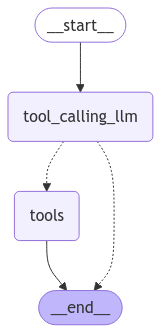

In [ ]:
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage

# Prepare the initial message from the human
messages = [HumanMessage(content="Hello world.")]

# Invoke the graph with the prepared messages
messages = graph.invoke({"messages": messages})

# Iterate through the returned messages and print each one
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Hello world.
================================== Ai Message ==================================

Hello world.


In [ ]:
# Import the HumanMessage class from langchain_core.messages
from langchain_core.messages import HumanMessage

# Prepare the initial message from the human with the content "Multiply 2 and 3."
messages = [HumanMessage(content="Multiply 2 and 3.")]

# Invoke the graph with the prepared messages
messages = graph.invoke({"messages": messages})

# Iterate through the returned messages and print each one
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Multiply 2 and 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (60e69f23-3ee6-4816-9fba-edeaa5a322f6)
 Call ID: 60e69f23-3ee6-4816-9fba-edeaa5a322f6
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6


Explanation of Comments:

1 Importing HumanMessage:

from langchain_core.messages import HumanMessage: This line imports the HumanMessage class from the langchain_core.messages module.

2 Preparing the Initial Message:

messages = [HumanMessage(content="Multiply 2 and 3.")]: This line creates a list containing a single HumanMessage with the content "Multiply 2 and 3."

3 Invoking the Graph:

messages = graph.invoke({"messages": messages}): This line invokes the graph with the prepared messages. The graph processes the messages and returns the updated state.

4 Iterating and Printing Messages:

for m in messages['messages']::: This line starts a loop that iterates through the returned messages in the updated state.

m.pretty_print(): This line prints each message using the pretty_print method for a formatted output.

In [ ]:
# Create tools for calculation
from langchain_google_genai import ChatGoogleGenerativeAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: First integer
        b: Second integer
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a: First integer
        b: Second integer
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: First integer
        b: Second integer
    """
    return a / b

# Define a list to store all the tools
tools = [add, multiply, divide]

# Bind tools with the language model
llm_with_tools = llm.bind_tools(tools)

In [ ]:
llm_with_tools  # get details of tool

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7bf194c246a0>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Add a and b.', 'parameters': {'properties': {'a': {'description': 'First integer', 'type': 'integer'}, 'b': {'description': 'Second integer', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.', 'parameters': {'properties': {'a': {'description': 'First integer', 'type': 'integer'}, 'b': {'description': 'Second integer', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a by b.', 'parameters': {'properties': {'a': {'description': 'First integer', 'ty

In [ ]:
# Import MessagesState from langgraph.graph
from langgraph.graph import MessagesState
# Import HumanMessage and SystemMessage from langchain_core.messages
from langchain_core.messages import HumanMessage, SystemMessage

# Create a system message that provides instructions for the assistant
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Define a function to create a node that processes the state
def assistant(state: MessagesState) -> MessagesState:
    # Invoke the LLM tools with the system message and the current state messages
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


In [ ]:
sys_msg

SystemMessage(content='You are a helpful assistant tasked with performing arithmetic on a set of inputs.', additional_kwargs={}, response_metadata={})

In [ ]:
# Import necessary modules from langgraph.graph for building the state graph
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# Import CompiledStateGraph for compiling the state graph
from langgraph.graph.state import CompiledStateGraph

from langgraph.prebuilt import tools_condition  # Determines routing to tools or end
from langgraph.prebuilt import ToolNode  # Special node for function calls

from IPython.display import Image, display  # Import IPython display classes

# Initialize the graph builder
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)  # Pass assistant function to assistant node
builder.add_node("tools", ToolNode(tools))  # Pass tools to ToolNode, enabling function calls and responses
# Note: ToolNode(tools) now serves as both a generator and an action node. It can call the functions and respond accordingly.


# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")  # Start by calling the assistant node

# Define conditional edges: determine routing based on the result
# Define the condition: The assistant node either routes to tools via the tool-condition or routes to END.
builder.add_conditional_edges(
    "assistant",
    tools_condition,  # Route to tools if the latest message from assistant is a tool call
    # Route to END if the latest message from assistant is not a tool call
)

# Define edge: tools call assistant
builder.add_edge("tools", "assistant")  # After tools, call assistant again

# Compile the graph to a reactive graph
graph: CompiledStateGraph = builder.compile()

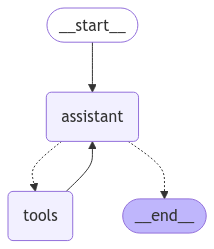

In [ ]:
# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Prepare the initial message from the human with the content "Add 3 and 4"
messages = [HumanMessage(content="Add 3 and 4")]

# Invoke the graph with the prepared messages
messages = graph.invoke({"messages": messages})

In [ ]:
# Iterate through the returned messages
for m in messages['messages']:
    # Print each message in a formatted manner
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (02105427-e0db-4b77-9479-909cfaa2d650)
 Call ID: 02105427-e0db-4b77-9479-909cfaa2d650
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [ ]:
messages = [HumanMessage(content="First Add 3 and 4 then multiply answer with 2 and then divide answer with 5. Dont perform division initially")]
messages = graph.invoke({"messages": messages})

In [ ]:
# Iterate through the returned messages
for m in messages['messages']:
    # Print each message in a formatted manner
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (02105427-e0db-4b77-9479-909cfaa2d650)
 Call ID: 02105427-e0db-4b77-9479-909cfaa2d650
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


# Agent memory

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## Goals

Now, we're going extend our agent by introducing memory.

In [ ]:
# Import the ChatGoogleGenerativeAI class
from langchain_google_genai import ChatGoogleGenerativeAI

# Define the multiply function
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int

    Returns:
        int: The product of a and b
    """
    return a * b

# This will be a tool: Define the add function
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int

    Returns:
        int: The sum of a and b
    """
    return a + b

# Define the divide function
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int

    Returns:
        float: The result of dividing a by b
    """
    return a / b

# List of tool functions
tools = [add, multiply, divide]

# Bind the tools with the language model
llm_with_tools = llm.bind_tools(tools)

In [ ]:
# Import necessary modules
from langgraph.graph import START, StateGraph  # Import START and StateGraph for building the graph
from langgraph.prebuilt import tools_condition, ToolNode  # Import tools_condition and ToolNode
from IPython.display import Image, display  # Import IPython display classes
from langgraph.graph.state import CompiledStateGraph  # Import CompiledStateGraph for compiling the graph

# Graph
builder: StateGraph = StateGraph(MessagesState)  # Initialize the state graph builder with MessagesState

# Define nodes: these do the work
builder.add_node("assistant", assistant)  # Add the assistant node, which processes the state
builder.add_node("tools", ToolNode(tools))  # Add the tools node, which handles tool invocations

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")  # Start the graph with the assistant node
builder.add_conditional_edges(
    "assistant",
    tools_condition,  # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is not a tool call -> tools_condition routes to END
)
builder.add_edge("tools", "assistant")  # Define the edge from tools back to assistant

# Compile the graph to a reactive state graph
graph: CompiledStateGraph = builder.compile()


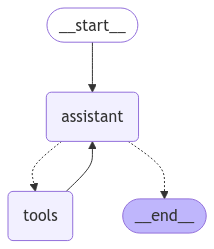

In [ ]:
# Show the graph
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))  # Display the graph using IPython display


In [ ]:
# Prepare the initial message from the human with the content "Add 3 and 4."
messages = [HumanMessage(content="Add 3 and 4.")]

# Invoke the reactive state graph with the prepared messages
messages = graph.invoke({"messages": messages})

In [ ]:
# Iterate through the returned messages
for m in messages['messages']:
    # Print each message in a formatted manner
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (8c270604-0515-4ec0-a22f-d4e8d7772ca0)
 Call ID: 8c270604-0515-4ec0-a22f-d4e8d7772ca0
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [ ]:
# Prepare the initial message from the human with the content "Multiply that by 2."
messages = [HumanMessage(content="Multiply that by 2.")]

# Invoke the reactive state graph with the prepared messages
messages = graph.invoke({"messages": messages})

In [ ]:
# Iterate through the returned messages
for m in messages['messages']:
    # Print each message in a formatted manner
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

What values would you like me to multiply by 2?


In [ ]:
# Import MemorySaver from langgraph.checkpoint.memory
from langgraph.checkpoint.memory import MemorySaver

# Create an instance of MemorySaver to handle the memory checkpoints
memory: MemorySaver = MemorySaver()

# Compile the state graph with memory checkpointer
react_graph_memory: CompiledStateGraph = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our memory location of graph states collection.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)

![state.png](https://github.com/panaversity/learn-agentic-ai-fundamentals/blob/main/03_langchain_ecosystem/langgraph/course-notebooks/module-1/image.png)


In [ ]:
# Specify a thread by creating a configuration dictionary with a thread ID
config = {"configurable": {"thread_id": "1"}}

# Prepare the initial message from the human with the content "Add 3 and 4."
messages = [HumanMessage(content="Add 3 and 4.")]

# Run the reactive state graph with the prepared messages and configuration
messages = react_graph_memory.invoke({"messages": messages}, config)


In [ ]:
# Iterate through the returned messages
for m in messages['messages']:
    # Print each message in a formatted manner
    m.pretty_print()


================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (be46cea5-f167-4a55-a068-61df0af57658)
 Call ID: be46cea5-f167-4a55-a068-61df0af57658
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [ ]:
# Prepare the initial message from the human with the content "Multiply that by 2."
messages = [HumanMessage(content="Multiply that by 2.")]

# Invoke the reactive state graph with the prepared messages and configuration
messages = react_graph_memory.invoke({"messages": messages}, config)

In [ ]:
# Iterate through the returned messages
for m in messages['messages']:
    # Print each message in a formatted manner
    m.pretty_print()
